**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Train and Evaluate Model](#2-bullet)
3. [Predictions](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [ ]:
from Data import *

ModuleNotFoundError: No module named 'Data'

In [30]:
import sys
import os

# Get the current working directory and the mounted drive path
# If your file is in a subdirectory of the mounted drive, specify the full path
drive_path = '/content/drive/MyDrive/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/SVR/' # <--- REPLACE WITH YOUR ACTUAL PATH TO THE DIRECTORY CONTAINING DataPreprocessing.py

# Add the directory to the system path
if drive_path not in sys.path:
    sys.path.append(drive_path)
    print(f"Added {drive_path} to sys.path")

# Now attempt to import the module
try:
    from DataPre import *
    print("DataPreprocessing module imported successfully!")
except ModuleNotFoundError:
    print(f"Error: Module 'DataPreprocessing' not found in {sys.path}")
    print("Please verify the path to the DataPreprocessing.py file and update drive_path.")


from google.colab import drive
drive.mount('/content/drive')

DataPreprocessing module imported successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
os.listdir(drive_path)
# print(sys.path)

['.DS_Store',
 '.ipynb_checkpoints',
 'DataPreprocessing.ipynb',
 'DataPre.py',
 'SVR - Day forward chaining.ipynb',
 'SVR-Model.ipynb',
 '__pycache__']

## 2. [Train and Evaluate Model](#2-bullet)

### Create dataset

In [33]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [34]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

In [35]:
training_size=int(len(dataset)*0.8)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3604, 1)
test_data:  (902, 1)


In [36]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (3573, 30)
y_train:  (3573, 1)
x_test:  (871, 30)
y_test (871, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [37]:
# Create and train the SVR model
svr_model = SVR(C = 1, kernel = 'linear', gamma = 0.01)
svr_model.fit(x_train, y_train)

SVR(C=1, gamma=0.01, kernel='linear')

In [38]:
predictions = svr_model.predict(x_test)
predictions = predictions.reshape(-1,1)

predictions_train = svr_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)

In [39]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [40]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

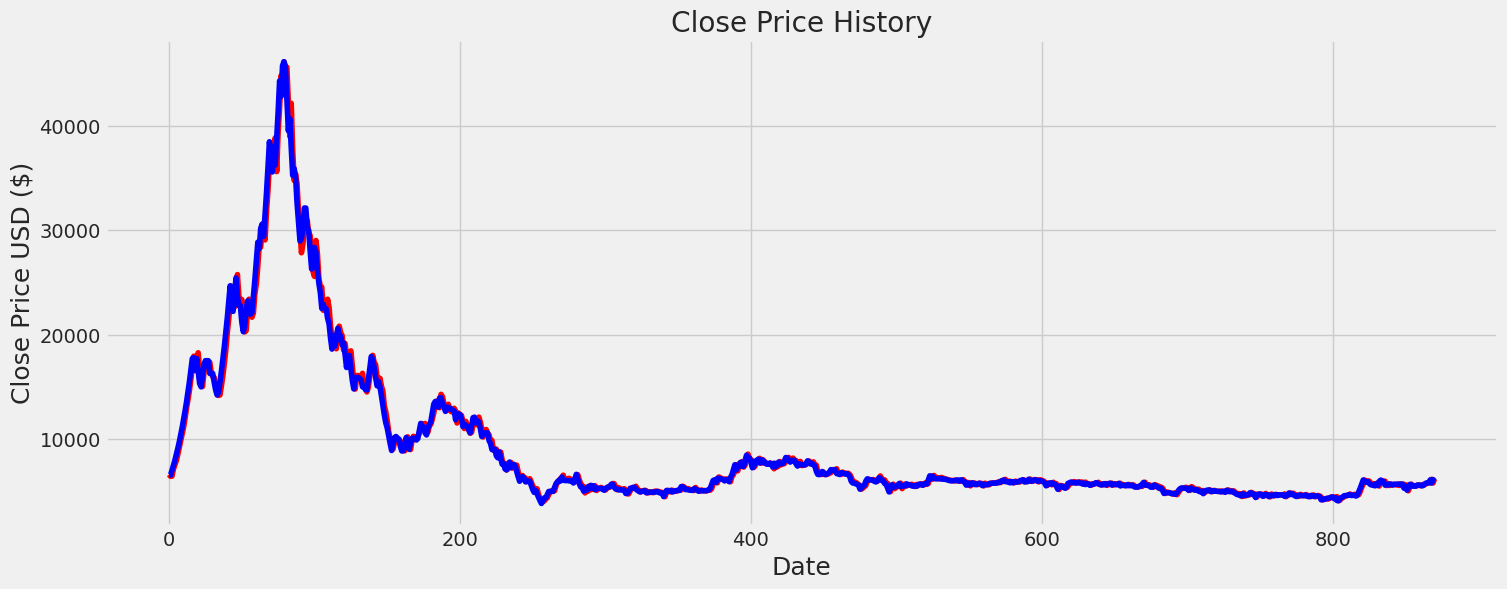

In [41]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [42]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [43]:
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.03247961333854286
Train Mean Squared Error: 0.0038940518139447032
Train R-squared: 0.9961059481860552


In [44]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.04356594007881832
Test Mean Squared Error: 0.006386558277890907
Test R-squared: 0.9936134417221091


## 3. [Predictions](#4-bullet)

In [45]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [47]:
last_60_days = np.array([y_test[i] for i in range(-1, -61, -1)])
next_days = []
for i in range(60):
    input_data = x_test[i-60].reshape(-1,30)

    predicted_price = svr_model.predict(input_data)
    next_days.append(predicted_price)

#
# pop_price = next_days.pop(0)
print("Predicted prices for the next days:")

for i, price in enumerate(next_days):
    price = scaler.inverse_transform(price.reshape(-1,1))
    print(f"Day {i+1}: {price}")

next_days = scaler.inverse_transform(np.array(next_days).reshape(-1,1))

Predicted prices for the next days:
Day 1: [[3871.96626728]]
Day 2: [[3960.4518474]]
Day 3: [[3880.46677109]]
Day 4: [[3882.22882725]]
Day 5: [[3939.0907502]]
Day 6: [[3869.53754307]]
Day 7: [[3856.6837712]]
Day 8: [[3923.33965717]]
Day 9: [[4177.31082637]]
Day 10: [[4493.71681324]]
Day 11: [[4742.32683984]]
Day 12: [[5050.28789911]]
Day 13: [[4987.47001336]]
Day 14: [[4963.49948751]]
Day 15: [[4977.70094696]]
Day 16: [[4850.72516672]]
Day 17: [[4738.88811628]]
Day 18: [[4694.93325443]]
Day 19: [[4763.57646196]]
Day 20: [[4626.04543926]]
Day 21: [[4829.35879907]]
Day 22: [[4580.89675105]]
Day 23: [[4961.29947754]]
Day 24: [[5004.06989545]]
Day 25: [[4832.70567042]]
Day 26: [[4963.85776548]]
Day 27: [[4618.50911255]]
Day 28: [[4772.38664177]]
Day 29: [[4624.14459972]]
Day 30: [[4714.01180865]]
Day 31: [[4696.797683]]
Day 32: [[4676.0879886]]
Day 33: [[4723.56719162]]
Day 34: [[4664.0949159]]
Day 35: [[4728.92534151]]
Day 36: [[4627.96896396]]
Day 37: [[4746.41588144]]
Day 38: [[4659.042

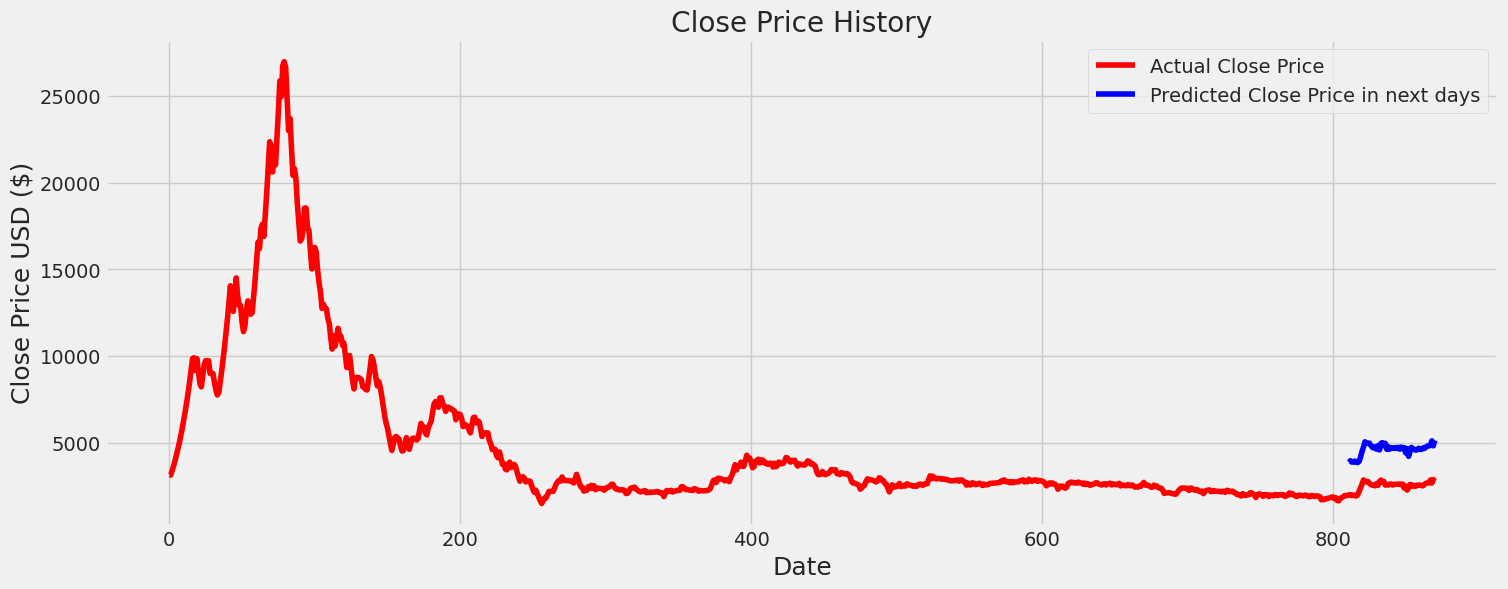

In [48]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(y_test[:], color='red', label='Actual Close Price')
plt.plot(range(len(y_test)-60, len(y_test)), next_days, color='blue', label='Predicted Close Price in next days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()